In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Reading in 1/4, 1/8, 1/16 or 1/32 degree NW2 data:

In [53]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline/
fs = xr.open_dataset('static.nc', decode_times=False)
av = xr.open_dataset('averages_00031502.nc', decode_times=False)  
os = xr.open_dataset('ocean.stats.nc', decode_times=False)


# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.125deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.0625deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00006002.nc', decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00001402.nc', decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [64]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = np.array(fs['depth_ocean'])
#depthmat = np.tile(depth,[15,1,1])
area_t=np.array(fs['area_t'])

xh = fs.xh.values
yh = fs.yh.values
dxh = fs.dxCu.values; dxh = dxh[:,1:] #(dxh[1:,:]+dxh[:-1,:])/2.
dyh = fs.dyCv.values; dyh = dyh[1:,:] #dyh = (dyh[:,1:]+dyh[:,:-1])/2.

Layer = np.array(os['Layer']);
drho=np.zeros(15);
drho[0]=Layer[0]; drho[1:]=np.diff(Layer)
print(drho); #drho contains the density differences across each interface. 15 entries, includes surface but not bottom.
#drhomat=np.transpose(np.tile(drho,[len(yh),len(xh),1]),[2,0,1])

[1.0226e+03 2.1000e-01 3.9000e-01 5.4000e-01 5.8000e-01 5.8000e-01
 5.7000e-01 5.3000e-01 4.8000e-01 4.2000e-01 3.7000e-01 3.1000e-01
 2.4000e-01 1.7000e-01 1.1000e-01]


In [65]:
#1/4 degree:560 lat x 240 lon 
#60,460 in 1/4 degree is nominal analysis point!
index_lon=60; index_lat=460 #1/4 degree: NW(60,460), ACC(60,80), (120,80), (200,80); Midlat: (60 or 120,400)


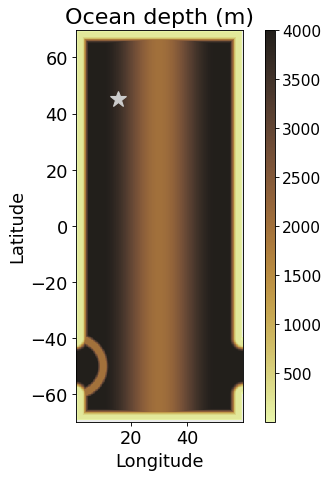

In [66]:
#Plotting ocean depth
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Ocean depth (m)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,depth,cmap=cmocean.cm.turbid)
ax1.plot(xh[index_lon],yh[index_lat],'*',markersize=15,color=[0.8, 0.8, 0.8])
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

## Reading in KE budget terms

In [67]:
#For entire water column:

box = 4; #half of number of grid points  of box over which we average
KEterm1 = (av['dKE_dt'][:,:,index_lat-box:index_lat+box,index_lon-box:index_lon+box]).mean(axis=2).mean(axis=2)
#assuming all of these are on the RHS of the KE equation
KEterm2 = (av['KE_CorAdv'][:,:,index_lat-box:index_lat+box,index_lon-box:index_lon+box]).mean(axis=2).mean(axis=2)
KEterm2_alternate = (av['KE_adv'][:,:,index_lat-box:index_lat+box,index_lon-box:index_lon+box]).mean(axis=2).mean(axis=2)
KEterm3 = (av['PE_to_KE'][:,:,index_lat-box:index_lat+box,index_lon-box:index_lon+box]).mean(axis=2).mean(axis=2)
KEterm4 = (av['KE_BT'][:,:,index_lat-box:index_lat+box,index_lon-box:index_lon+box]).mean(axis=2).mean(axis=2)
KEterm5 = (av['KE_visc'][:,:,index_lat-box:index_lat+box,index_lon-box:index_lon+box]).mean(axis=2).mean(axis=2)
KEterm6 = (av['KE_horvisc'][:,:,index_lat-box:index_lat+box,index_lon-box:index_lon+box]).mean(axis=2).mean(axis=2)
KE_stress = (av['KE_stress'][:,:,index_lat-box:index_lat+box,index_lon-box:index_lon+box]).mean(axis=2).mean(axis=2)

KEterm1 = KEterm1.mean(axis=0);
KEterm2 = KEterm2.mean(axis=0);
KEterm2_alternate = (KEterm2_alternate).mean(axis=0);
KEterm3 = KEterm3.mean(axis=0);
KEterm4 = KEterm4.mean(axis=0);
KEterm5 = KEterm5.mean(axis=0);
KEterm6 = KEterm6.mean(axis=0);
KE_stress = KE_stress.mean(axis=0);

E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
E_alternate = KEterm1-KEterm2_alternate-KEterm3-KEterm4-KEterm5-KEterm6

# #For entire water column at one point:

# KEterm1 = (av['dKE_dt'][:,:,index_lat,index_lon])
# #assuming all of these are on the RHS of the KE equation
# KEterm2 = (av['KE_CorAdv'][:,:,index_lat,index_lon])
# KEterm2_alternate = (av['KE_adv'][:,:,index_lat,index_lon])
# KEterm3 = (av['PE_to_KE'][:,:,index_lat,index_lon])
# KEterm4 = (av['KE_BT'][:,:,index_lat,index_lon])
# KEterm5 = (av['KE_visc'][:,:,index_lat,index_lon])
# KEterm6 = (av['KE_horvisc'][:,:,index_lat,index_lon])

# KEterm1 = KEterm1.mean(axis=0);
# KEterm2 = KEterm2.mean(axis=0);
# KEterm2_alternate = (KEterm2_alternate).mean(axis=0);
# KEterm3 = KEterm3.mean(axis=0);
# KEterm4 = KEterm4.mean(axis=0);
# KEterm5 = KEterm5.mean(axis=0);
# KEterm6 = KEterm6.mean(axis=0);

# E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
# E_alternate = KEterm1-KEterm2_alternate-KEterm3-KEterm4-KEterm5-KEterm6


In [68]:
h = np.array(av['h'][:,:,index_lat,index_lon]);
eta = np.zeros([100,len(Layer)]);

for i in range(0,len(Layer)):
    for j in range(0,100):
        eta[j,i]=np.nansum(h[j,0:i+1])  
    print(i)
    
eta[:,:-1]=(eta[:,1:]+eta[:,:-1])/2. #add bottom BC point at topography where u,v=0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [69]:
zl = np.nanmean(eta,axis=0)
zl.shape



(15,)

Text(0.5, 1.0, '1/4$^\\circ$ KE budget terms')

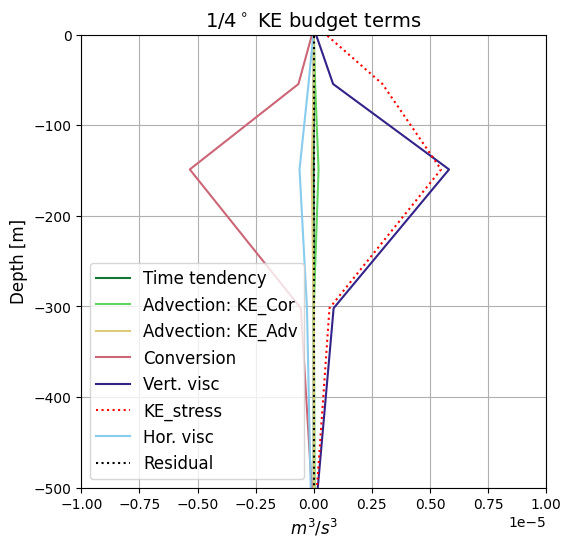

In [72]:
plt.figure(figsize=(6, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(KEterm1,-zl,'-',c='#117733')
plt.plot(KEterm2-KEterm2_alternate,-zl,'-',c='#60D55D')
plt.plot(KEterm2_alternate,-zl,'-',c='#ddcc77')
plt.plot(KEterm3+KEterm4,-zl,'-',c='#cc6677')
plt.plot(KEterm5,-zl,'-',c='#332288')
plt.plot(KE_stress,-zl,':r')

plt.plot(KEterm6,-zl,'-',c='#88ccee')
plt.plot(E,-zl,':',c='k')





plt.grid()
plt.legend(['Time tendency','Advection: KE_Cor','Advection: KE_Adv','Conversion','Vert. visc','KE_stress','Hor. visc','Residual'],fontsize=12)
#plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
plt.xlim(-1e-5, 1e-5)
plt.ylim(-500,0);
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('$m^3/s^3$',fontsize=12)
plt.ylabel('Depth [m]',fontsize=12)
plt.title('1/4$^\circ$ KE budget terms',fontsize=14)

In [14]:
# plt.figure(figsize=(6, 6), dpi= 100, facecolor='w', edgecolor='k')
# plt.plot(KEterm1,-zl,'-',c='#117733',linewidth=4)
# plt.plot(KEterm2-KEterm2_alternate,-zl,'-',c='#60D55D',linewidth=4)
# plt.plot(KEterm2_alternate,-zl,'-',c='#ddcc77',linewidth=4)
# plt.plot(KEterm3+KEterm4,-zl,'-',c='#cc6677',linewidth=4)
# plt.plot(KEterm5,-zl,'-',c='#332288',linewidth=4)
# plt.plot(KEterm6,-zl,'-',c='#88ccee',linewidth=4)
# plt.plot(E,-zl,':',c='k',linewidth=3)





# plt.grid()
# plt.legend(['Time tendency','Advection: KE_Cor','Advection: KE_Adv','Conversion','Vert. visc','Hor. visc','Residual'],fontsize=12)
# #plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
# plt.xlim(-1e-5, 1e-5)
# plt.ylim(-3600,0);
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# plt.xlabel('$m^3/s^3$',fontsize=12)
# plt.ylabel('Depth [m]',fontsize=12)
# plt.title('1/16$^\circ$ KE budget terms',fontsize=14)

In [ ]:
print('done')